# road track based on kalman filter

In [1]:
%matplotlib notebook

import numpy as np
import os
import scipy

from matplotlib import pyplot as plt
from matplotlib import colors
from osgeo import gdal
import skimage
from skimage import exposure
from skimage.segmentation import quickshift, felzenszwalb
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
import cv2

FILEPATH_SOURCE_DATA = "processing/Aoti_fill.img"
FILEPATH_ROAD_SEED = "processing/road_seed.tif"

In [2]:
# read source data 
source_data = gdal.Open(FILEPATH_SOURCE_DATA, gdal.GA_ReadOnly)
geo_transform = source_data.GetGeoTransform()
proj = source_data.GetProjectionRef()
n_bands = source_data.RasterCount
bands_data = []
for b in range(1, n_bands+1):
    band = source_data.GetRasterBand(b)
    bands_data.append(band.ReadAsArray())
bands_data = np.dstack(b for b in bands_data)

In [3]:
# secify the band information
elevation = bands_data[:, :, 0]
intensity = bands_data[:, :, 1]

note: scikit-image process image data in[-1, 1]

<IPython.core.display.Javascript object>


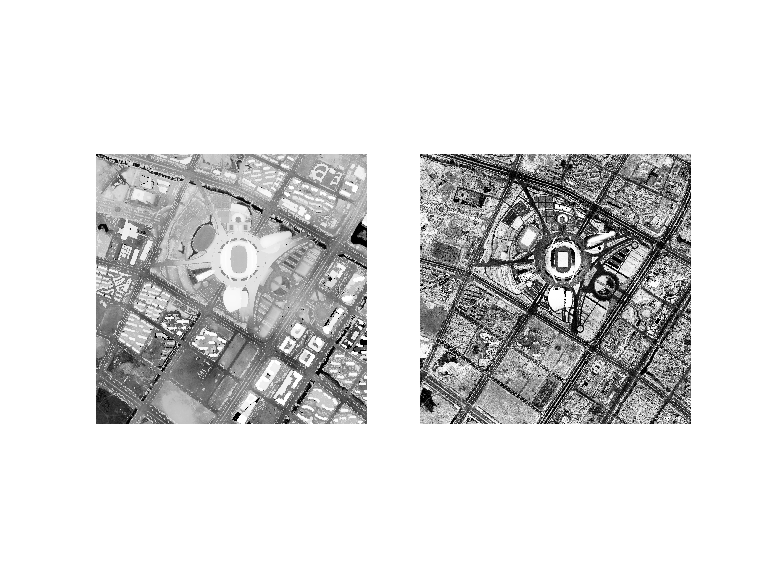

(-0.5, 1999.5, 1999.5, -0.5)

In [4]:
ratio_ele = 255/(elevation.max() - elevation.min())
rescale_ele = (elevation - elevation.min()) * ratio_ele

intensity[intensity>100] = 100
ratio_its = 255/(intensity.max() - intensity.min())
rescale_its = (intensity - intensity.min()) * ratio_its

#display the intensity figure after equalize histogram
equHist_its = exposure.equalize_hist(rescale_its)
equHIst_ele = exposure.equalize_hist(rescale_ele) 
plt.figure()
plt.subplot(1,2,1)
plt.imshow(equHIst_ele, cmap='gray')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(equHist_its, cmap='gray')
plt.axis('off')

<IPython.core.display.Javascript object>


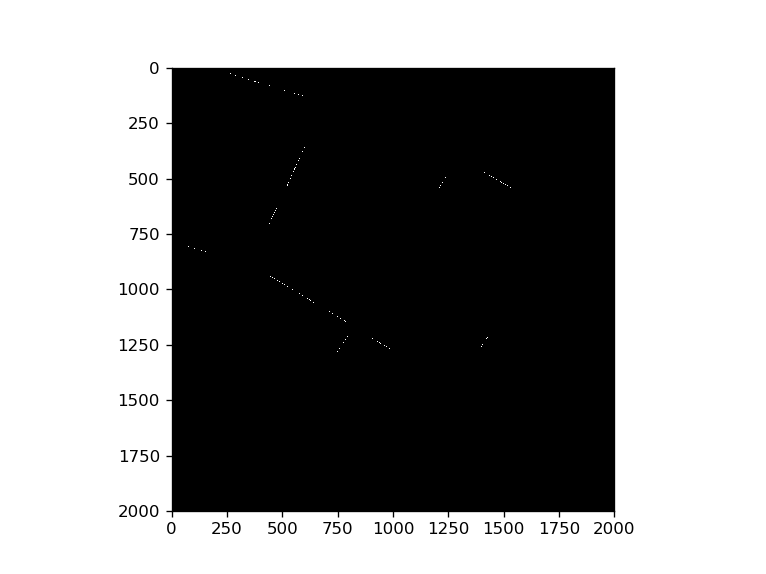

In [5]:
# read source data 
road_seed = gdal.Open(FILEPATH_ROAD_SEED, gdal.GA_ReadOnly)
band = road_seed.GetRasterBand(1)
road_seed_data = band.ReadAsArray().astype(np.uint8)
plt.figure()
plt.imshow(road_seed_data, cmap='gray')

In [6]:
rho = 1  # distance resolution in pixels of the Hough grid
theta = np.pi / 180  # angular resolution in radians of the Hough grid
threshold = 15  # minimum number of votes (intersections in Hough grid cell)
min_line_length = 50  # minimum number of pixels making up a line
max_line_gap = 20  # maximum gap in pixels between connectable line segments
lines = cv2.HoughLinesP(road_seed_data, rho, theta, threshold, np.array([]),
                    min_line_length, max_line_gap)

line_image = np.copy(road_seed_data) * 0
for line in lines:
    for x1,y1,x2,y2 in line:
        cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),5)

<IPython.core.display.Javascript object>


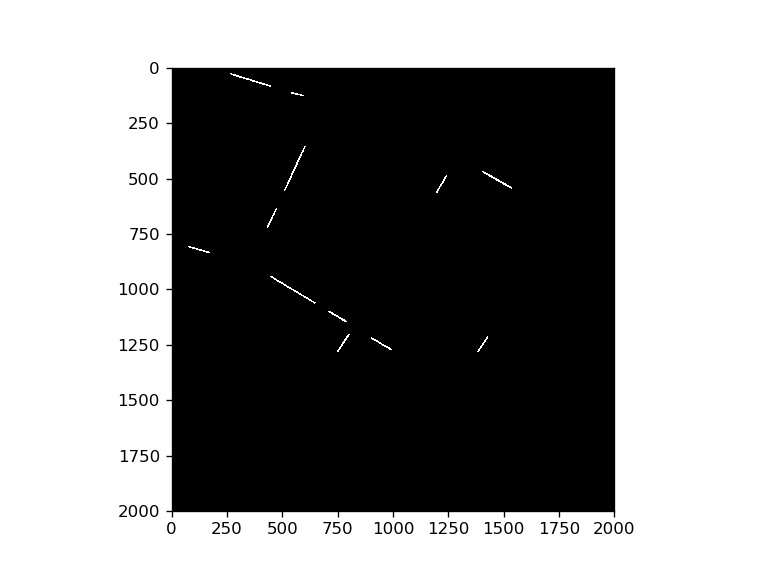

In [7]:
plt.figure()
plt.imshow(line_image, cmap='gray')

In [8]:
'''
x = []
y = []
for line in lines:
    for x1,y1,x2,y2 in line:
        x = np.append(x, np.array([x1,x2]))
        y = np.append(y, np.array([y1,y2]))
plt.imshow(line_image, cmap='gray')
plt.plot(x, y,'r*')
plt.show()
'''

"\nx = []\ny = []\nfor line in lines:\n    for x1,y1,x2,y2 in line:\n        x = np.append(x, np.array([x1,x2]))\n        y = np.append(y, np.array([y1,y2]))\nplt.imshow(line_image, cmap='gray')\nplt.plot(x, y,'r*')\nplt.show()\n"

In [9]:
def vector_direction(v):
    """ Returns the direction angle of vectors v1::

            >>> vector_direction((1, 0))
            0.0
            >>> angle_between((1, 1)
    """
    base = np.array([1, 0])
    v = v / np.linalg.norm(v)
    return np.sign(v[1]) * np.arccos(np.clip(np.dot(v, base), -1.0, 1.0))

In [10]:
def get_profile(image, r, c, theta, road_width=10):
    src = np.array([r - road_width * np.cos(theta), c + road_width * np.sin(theta)])
    dst = np.array([r + road_width * np.cos(theta), c - road_width * np.sin(theta)])
    profile = skimage.measure.profile_line(image, src, dst, linewidth=3, order=0, mode='constant', cval=0.0)
    return profile

In [11]:
'''
c1, r1, c2, r2 = x1, y1, x2, y2 = lines[2, 0]

vector12 = np.array([x1-x2, y1-y2])
theta = vector_direction(vector12)
road_width = 30
src = np.array([x1 + road_width * np.sin(theta), y1 - road_width * np.cos(theta)])
dst = np.array([x1 - road_width * np.sin(theta), y1 + road_width * np.cos(theta)])

plt.figure()
plt.imshow(equHIst_ele, cmap='gray', interpolation='None')
plt.plot(np.array([x1, src[0], dst[0]]), np.array([y1, src[1], dst[1]]),'r*')
#plt.plot(src[0], src[1],'r*')
plt.show()
'''

"\nc1, r1, c2, r2 = x1, y1, x2, y2 = lines[2, 0]\n\nvector12 = np.array([x1-x2, y1-y2])\ntheta = vector_direction(vector12)\nroad_width = 30\nsrc = np.array([x1 + road_width * np.sin(theta), y1 - road_width * np.cos(theta)])\ndst = np.array([x1 - road_width * np.sin(theta), y1 + road_width * np.cos(theta)])\n\nplt.figure()\nplt.imshow(equHIst_ele, cmap='gray', interpolation='None')\nplt.plot(np.array([x1, src[0], dst[0]]), np.array([y1, src[1], dst[1]]),'r*')\n#plt.plot(src[0], src[1],'r*')\nplt.show()\n"

<IPython.core.display.Javascript object>


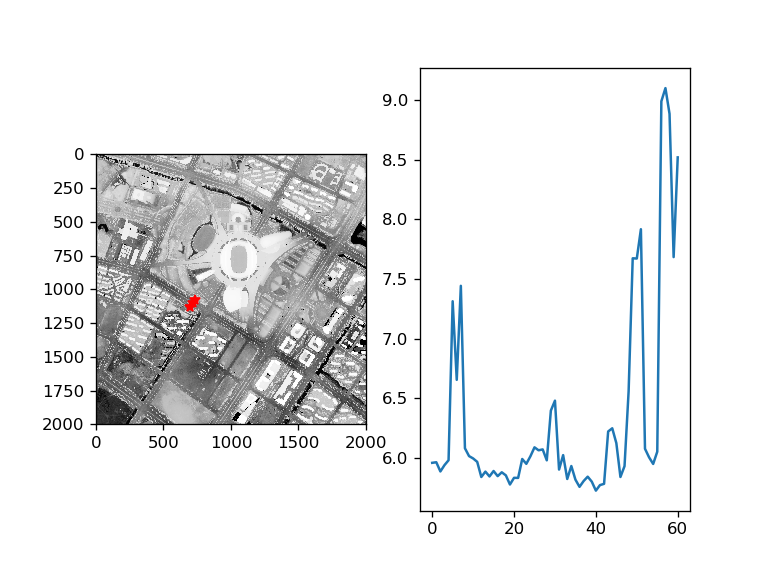

In [12]:
c1, r1, c2, r2 = x1, y1, x2, y2 = lines[0, 0]
theta = theta = vector_direction(np.array([c1-c2, r1-r2]))
profile = get_profile(elevation, r1, c1, theta, road_width=30)
#profile1 = skimage.measure.profile_line(equHIst_ele, src, dst, linewidth=1, order=1, mode='constant', cval=0.0)
#profile2 = skimage.measure.profile_line(equHIst_ele, src, dst, linewidth=1, order=2, mode='constant', cval=0.0)
#profile3 = skimage.measure.profile_line(equHIst_ele, src, dst, linewidth=1, order=4, mode='constant', cval=0.0)
axis_x = np.arange(0, profile.shape[0], 1)
plt.figure()

road_width = 30
src = np.array([x1 + road_width * np.sin(theta), y1 - road_width * np.cos(theta)])
dst = np.array([x1 - road_width * np.sin(theta), y1 + road_width * np.cos(theta)])

plt.subplot(1,2,1)
plt.imshow(equHIst_ele, cmap='gray', interpolation='None')
plt.plot(np.array([x1, src[0], dst[0]]), np.array([y1, src[1], dst[1]]),'r*')

plt.subplot(1,2,2)
plt.plot(axis_x, profile)
plt.show()

In [15]:
import sys
sys.path.append("D:\RoadExtract\code")

In [17]:
from road_kalman import RoadEKF

In [18]:
dt = 3
road_tracker = RoadEKF(dt)